In [1]:
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.dagcircuit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer
from qcg.generators import gen_supremacy
from qiskit import *
from qiskit.visualization import plot_state_city
import numpy as np
import functools
import timeit
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import cm

dimensions = range(1,6)
num_qubits = [x*x for x in dimensions]
sv_times = np.zeros((len(dimensions), len(dimensions)))
qasm_times = np.zeros((len(dimensions), len(dimensions)))
difference = np.zeros((len(dimensions), len(dimensions)))

for i in dimensions:
    for j in dimensions:
        if i*j<=20:
            circ = gen_supremacy(i,j,8,order='75601234')

            sv_start = timeit.default_timer()
            backend = BasicAer.get_backend('statevector_simulator')
            job = execute(circ, backend)
            result = job.result()
            outputstate = result.get_statevector(circ)
            sv_outputprob = [np.power(abs(x),2) for x in outputstate]
            sv_end = timeit.default_timer()
            sv_times[i-1,j-1] = sv_end-sv_start

            qasm_start = timeit.default_timer()
#             num_measurements = max(1024,int(np.power(2,i*j)))
            num_measurements = 1024
            c = ClassicalRegister(i*j, 'c')
            meas = QuantumCircuit(circ.qregs[0], c)
            meas.barrier(circ.qubits)
            meas.measure(circ.qubits,c)
            qc = circ+meas

            backend_sim = BasicAer.get_backend('qasm_simulator')
            job_sim = execute(qc, backend_sim, shots=num_measurements)
            result_sim = job_sim.result()
            counts = result_sim.get_counts(qc)
            qasm_outputprob = [counts[x]/num_measurements for x in counts]
            qasm_end = timeit.default_timer()
            qasm_times[i-1,j-1] = qasm_end-qasm_start
            difference[i-1,j-1] = sv_times[i-1,j-1] - qasm_times[i-1,j-1]
        else:
            sv_times[i-1,j-1] = 0
            qasm_times[i-1,j-1] = 0
            difference[i-1,j-1] = sv_times[i-1,j-1] - qasm_times[i-1,j-1]

print('sv_times:\n', sv_times)
print('qasm_times:\n', qasm_times)
print('sv - qasm:\n', difference)

sv_times:
 [[ 0.02927387  0.02653775  0.0271927   0.03219255  0.03569046]
 [ 0.01528807  0.03519182  0.04881692  0.06398858  0.08227776]
 [ 0.02303642  0.05072867  0.12717998  0.1319311   0.42399021]
 [ 0.03008589  0.06580938  0.12652403  0.71429167 10.483144  ]
 [ 0.09162072  0.10877048  0.39480084 11.33438538  0.        ]]
qasm_times:
 [[0.02325874 0.02684683 0.03432969 0.03877941 0.04558578]
 [0.02076343 0.04047135 0.06074051 0.08284945 0.09703112]
 [0.02949082 0.06262607 0.09432466 0.13413142 0.20496063]
 [0.03861212 0.08152888 0.126642   0.29143968 2.91838889]
 [0.04424542 0.14627558 0.21582626 3.73635866 0.        ]]
sv - qasm:
 [[ 6.01513800e-03 -3.09075000e-04 -7.13698400e-03 -6.58685900e-03
  -9.89532100e-03]
 [-5.47536000e-03 -5.27953400e-03 -1.19235910e-02 -1.88608660e-02
  -1.47533600e-02]
 [-6.45440300e-03 -1.18973970e-02  3.28553230e-02 -2.20032000e-03
   2.19029583e-01]
 [-8.52623700e-03 -1.57194930e-02 -1.17972000e-04  4.22851986e-01
   7.56475512e+00]
 [ 4.73753090e-02

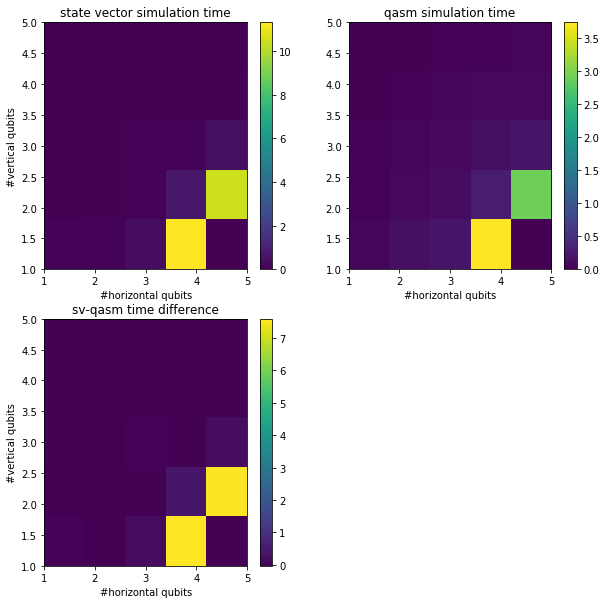

In [2]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(sv_times, aspect='auto',
           extent=[min(dimensions), max(dimensions), min(dimensions), max(dimensions)], cmap = cm.viridis)
plt.xlabel('#horizontal qubits')
plt.ylabel('#vertical qubits')
plt.title('state vector simulation time')
plt.colorbar()
plt.subplot(222)
plt.imshow(qasm_times, aspect='auto',
           extent=[min(dimensions), max(dimensions), min(dimensions), max(dimensions)], cmap = cm.viridis)
plt.colorbar()
plt.xlabel('#horizontal qubits')
plt.title('qasm simulation time')
plt.subplot(223)
plt.imshow(difference, aspect='auto',
           extent=[min(dimensions), max(dimensions), min(dimensions), max(dimensions)], cmap = cm.viridis)
plt.colorbar()
plt.title('sv-qasm time difference')
plt.xlabel('#horizontal qubits')
plt.ylabel('#vertical qubits')
plt.show()